## Import libraries

In [1]:
import time
import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext import data
from torchtext import datasets
from torch.autograd import Variable

Philos: The following makes our neural network model determinisic

Xiaoli: Would that affect training speed?

In [2]:
SEED = 2020
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
TEXT = data.Field(tokenize = 'spacy', batch_first = True, include_lengths = True)
LABEL = data.LabelField(batch_first = True)
#LABEL = data.LabelField(dtype = torch.float, batch_first = True)
train, test = datasets.IMDB.splits(TEXT, LABEL)

In [4]:
# I added a validation dataset
import random

train, val = train.split(random_state = random.seed(SEED))

In [6]:
TEXT.build_vocab(train, vectors="glove.6B.100d",max_size=10000, min_freq=10)
LABEL.build_vocab(train)
len(TEXT.vocab.stoi)

10002

## Import datasets

In [7]:
# I increased the batch size since it will return more stable output
batch_size = 128

In [8]:
# I set shuffle to False so that we can test training the model on the first few batches  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), batch_size=batch_size, sort_within_batch = True, device=device, shuffle=True)
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


## Recurrent Models 

In [9]:
# I added a sigmoid layer in th model and replaced BCEWithLogitsLoss() to BCELoss(), 
# This is mostly because I wanted to know whether the problem occured in the sigmoid layer, or in the loss function
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        
        super().__init__()
        
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = 2, 
                            bidirectional = True, 
                            dropout = 0.2, 
                            batch_first = True)
        
        self.fc = nn.Linear(hidden_dim*2, 1)
        self.act = nn.Sigmoid()
                
    def forward(self, text, text_lengths):

        x_padded = nn.utils.rnn.pad_sequence(text, batch_first=True, padding_value=0)
        embedded = self.embedding(text)

        # packed padded sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first = True)
        out, (hidden, cell) = self.lstm(packed_embedded)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        logits = self.fc(hidden)
        prob = self.act(logits)
        
        return prob
    
    
# Captum Convolutional Model
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        #text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)

        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)


## Training

In [10]:
# I increased the hidden dimension from 8 to 100
model = LSTMClassifier(input_dim = len(TEXT.vocab.stoi), 
                       embedding_dim = 100,
                       hidden_dim = 100)

print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_parameters = count_parameters(model)

print("The model has {} trainable parameters".format(num_parameters))

model.embedding.weight.data = TEXT.vocab.vectors
model.embedding.weight.requires_grad = False

num_parameters = count_parameters(model)

print("The model has {} trainable parameters".format(num_parameters))

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad == True], lr=0.01)
criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

LSTMClassifier(
  (embedding): Embedding(10002, 100)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 1403601 trainable parameters
The model has 403401 trainable parameters


In [11]:
from my_tools import binary_accuracy, f1, fpr, fnr, binary_acc
import pandas as pd
import numpy as np


In [14]:
# I initially tested on only a few batches, to make sure the training loss decreases
def train_loop(model, iterator):
    avg_loss = 0.
    
    model.train()
    count = 0
    
    all_preds = []
    all_labels = []
    for batch in iterator:
        text, text_lengths = batch.text
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions.float(), Variable(batch.label.float()))
        loss.backward()
        optimizer.step()

        all_preds.append(torch.round(predictions).detach().cpu().numpy())
        all_labels.append(batch.label.detach().cpu().numpy())

        avg_loss += loss.item()
        
    return avg_loss / len(iterator), np.concatenate(all_preds), np.concatenate(all_labels)
    #return epoch_loss / 100, epoch_acc / 100

# For validation/testing data; it's the same as train_loop but doesn't update the model weights
def evaluate(model, iterator):
    avg_loss = 0.0
    
    model.eval()
    
    all_preds = []
    all_labels = []
    
    for batch in iterator:
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions.float(), batch.label.float())
        all_preds.append(torch.round(predictions).detach().cpu().numpy())
        all_labels.append(batch.label.detach().cpu().numpy())
        avg_loss += loss.item()
    
    return avg_loss / len(iterator), np.concatenate(all_preds), np.concatenate(all_labels)

In [15]:
# This line disables CUDNN, which makes my code run slower but also prevents the CUDNN errors I've been getting
torch.backends.cudnn.enabled = False

t = time.time()

train_losses = []
val_losses = []

BOLD = "\033[1m"
END = "\033[0m"

for epoch in range(1,16):
    loss, preds, labels = train_loop(model, train_iter)
    val_loss, val_preds, val_labels = evaluate(model, val_iter)
    if epoch % 1 == 0:
        print(BOLD + "Epoch {}".format(epoch) + END)
        print(f'Train Loss: {loss:.3f} | Train Acc: {binary_acc(preds, labels):.2f} | Train F1: {f1(preds, labels):.2f}')
        print('\t# 1s:', (preds == 1).sum(), '#0s:', (preds == 0).sum())
        print(f'Val Loss: {val_loss:.3f} | Val Acc: {binary_acc(val_preds, val_labels):.2f} | Val F1: {f1(val_preds, val_labels):.2f}')
        train_losses.append(loss)
        val_losses.append(val_loss)
        
print(f'time:{time.time()-t:.3f}')

torch.save(model, 'models/lstm.pt')

Epoch 1
Train Loss: 0.613 | Train Acc: 0.65 | Train F1: 0.67
	# 1s: 9957 #0s: 7543
Val Loss: 0.604 | Val Acc: 0.67 | Val F1: 0.75
Epoch 2
Train Loss: 0.459 | Train Acc: 0.80 | Train F1: 0.80
	# 1s: 9125 #0s: 8375
Val Loss: 0.385 | Val Acc: 0.84 | Val F1: 0.85
Epoch 3
Train Loss: 0.370 | Train Acc: 0.84 | Train F1: 0.84
	# 1s: 8862 #0s: 8638
Val Loss: 0.339 | Val Acc: 0.85 | Val F1: 0.85
Epoch 4
Train Loss: 0.324 | Train Acc: 0.86 | Train F1: 0.86
	# 1s: 8814 #0s: 8686
Val Loss: 0.320 | Val Acc: 0.86 | Val F1: 0.86
Epoch 5
Train Loss: 0.291 | Train Acc: 0.88 | Train F1: 0.88
	# 1s: 8699 #0s: 8801
Val Loss: 0.311 | Val Acc: 0.87 | Val F1: 0.88
Epoch 6
Train Loss: 0.267 | Train Acc: 0.89 | Train F1: 0.89
	# 1s: 8780 #0s: 8720
Val Loss: 0.286 | Val Acc: 0.88 | Val F1: 0.88
Epoch 7
Train Loss: 0.235 | Train Acc: 0.91 | Train F1: 0.91
	# 1s: 8732 #0s: 8768
Val Loss: 0.315 | Val Acc: 0.86 | Val F1: 0.87
Epoch 8
Train Loss: 0.210 | Train Acc: 0.92 | Train F1: 0.92
	# 1s: 8721 #0s: 8779
Val Los

C:\Users\Philos\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LSTMClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Text(0.5, 0.98, 'Training Losses')

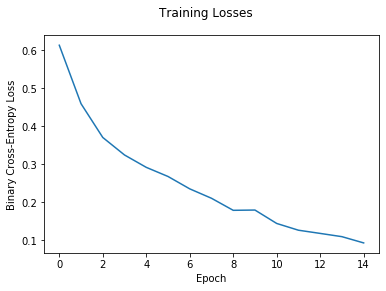

In [19]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.suptitle("Training Losses")

## Confusion Matrix

In [12]:
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.ylim([1.5, -.5])
    return ax

## Testing

In [17]:
model = torch.load('models/lstm.pt')
model.eval()
model.to(device)

loss_all, preds_all, labels_all = evaluate(model, test_iter)


Confusion matrix, without normalization
[[10364  2136]
 [ 1013 11487]]
FPR: 0.17088 | FNR: 0.08104 | Train F1: 0.87945 | MCC: 0.75112


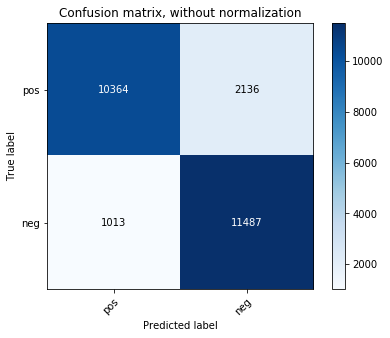

In [19]:
from sklearn.metrics import matthews_corrcoef, f1_score

f1_all = f1_score(preds_all, labels_all)
fpr_all = fpr(preds_all, labels_all)
fnr_all = fnr(preds_all, labels_all)
mcc_all = matthews_corrcoef(labels_all, preds_all)

plot_confusion_matrix(labels_all, preds_all, classes = np.array(["pos", "neg"]))
print(f'FPR: {fpr_all:.5f} | FNR: {fnr_all:.5f} | Train F1: {f1_all:.5f} | MCC: {mcc_all:.5f}')

## Split Data by Demographic Keyword

In [20]:
pooled_reviews = []
black_reviews = []
white_reviews = []
asian_reviews = []
hispanic_reviews = []

test_iter = iter(test)

identifiers = ["man", "men", "woman", "women", "person", "people", "guy", "girl"]

for i, review in enumerate(test_iter):
    for j, word in enumerate(review.text):
        if word.lower() in ["black", "african"] and j < len(review.text):
            if review.text[j + 1] in identifiers:
                black_reviews.append(review)
                pooled_reviews.append(review)
        elif word.lower() in ["white", "caucasian", "european"] and j < len(review.text):
            if review.text[j + 1] in identifiers:
                white_reviews.append(review)
                pooled_reviews.append(review)
        elif word.lower() in ["asian"]:
            asian_reviews.append(review)
            pooled_reviews.append(review)
        elif word.lower() in ["hispanic", "latino", "latina", "mexican", "cuban"]:
            hispanic_reviews.append(review)
            pooled_reviews.append(review)
            
pooled_reviews = list(set(pooled_reviews))
black_reviews = list(set(black_reviews))
white_reviews = list(set(white_reviews))
asian_reviews = list(set(asian_reviews))
hispanic_reviews = list(set(hispanic_reviews))

print("Length of test dataset: {}".format(len(test)))
print("Number of reviews containing black demographic keywords: {}".format(len(black_reviews)))
print("Number of reviews containing white demographic keywords: {}".format(len(white_reviews)))
print("Number of reviews containing asian demographic keywords: {}".format(len(asian_reviews)))
print("Number of reviews containing hispanic demographic keywords: {}".format(len(hispanic_reviews)))
print("Number of reviews containing ethnic demographic keywords: {}".format(len(pooled_reviews)))

Length of test dataset: 25000
Number of reviews containing black demographic keywords: 181
Number of reviews containing white demographic keywords: 109
Number of reviews containing asian demographic keywords: 181
Number of reviews containing hispanic demographic keywords: 193
Number of reviews containing ethnic demographic keywords: 605


## Find and replace all Ethnic keywords

In [22]:
black_identifiers = ["black", "african"]
white_identifiers = ["white", "caucasian", "european"]
asian_identifiers = ["asian"]
hispanic_identifiers = ["hispanic", "latino", "latina"]

ethnic_identifiers = black_identifiers + white_identifiers + asian_identifiers + hispanic_identifiers

def replace(ethnic_identifiers, replacement, all_reviews):
    for review in all_reviews:
        for j, word in enumerate(review.text):
            if word.lower() in ethnic_identifiers and j < len(review.text) and review.text[j + 1] in identifiers:
                review.text[j] = replacement
    
    return all_reviews

# Replace all ethnic keywords with white

white_reviews = replace(ethnic_identifiers, "white", pooled_reviews)
black_reviews = replace(ethnic_identifiers, "black", pooled_reviews)
asian_reviews = replace(ethnic_identifiers, "asian", pooled_reviews)
hispanic_reviews = replace(ethnic_identifiers, "hispanic", pooled_reviews)

### Sample 100 reviews from each keyword dataset without replacement

In [23]:
import random

black_reviews_sample = random.sample(black_reviews, 100)
white_reviews_sample = random.sample(black_reviews, 100)
asian_reviews_sample = random.sample(black_reviews, 100)
hispanic_reviews_sample = random.sample(black_reviews, 100)

print(len(black_reviews_sample))

100


In [24]:
test_black_data = data.Dataset(black_reviews_sample,[('label', LABEL),('text', TEXT)])
test_white_data = data.Dataset(white_reviews_sample,[('label', LABEL),('text', TEXT)])
test_asian_data = data.Dataset(asian_reviews_sample,[('label', LABEL),('text', TEXT)])
test_hispanic_data = data.Dataset(hispanic_reviews_sample,[('label', LABEL),('text', TEXT)])

FPR: 0.11765 | FNR: 0.04082 | Train F1: 0.92157
Confusion matrix, without normalization
[[45  6]
 [ 2 47]]


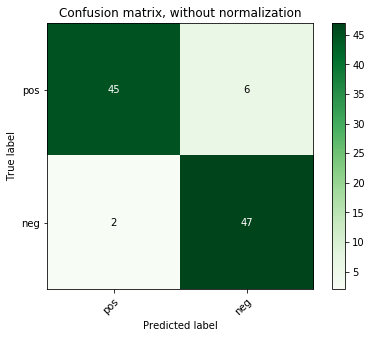

In [25]:
test_black_iter = data.BucketIterator(test_black_data, \
                                      batch_size=batch_size,
                                      sort_key = lambda x: len(x.text),
                                      sort_within_batch = True, 
                                      device=device, shuffle=True)

loss_black, preds_black, labels_black = evaluate(model, test_black_iter)

f1_black = f1_score(preds_black, labels_black)
fpr_black = fpr(preds_black, labels_black)
fnr_black = fnr(preds_black, labels_black)
print(f'FPR: {fpr_black:.5f} | FNR: {fnr_black:.5f} | Train F1: {f1_black:.5f}')

plot_confusion_matrix(labels_black, preds_black, classes = np.array(["pos", "neg"]), cmap = "Greens")

FPR: 0.14062 | FNR: 0.11111 | Train F1: 0.83117
Confusion matrix, without normalization
[[55  9]
 [ 4 32]]


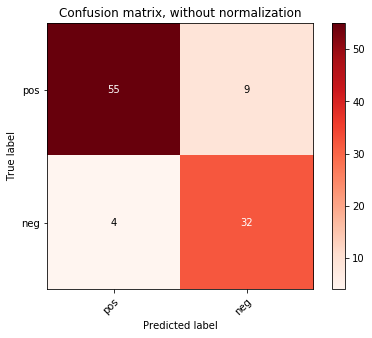

In [26]:
test_white_iter = data.BucketIterator(test_white_data, \
                                      batch_size=batch_size,
                                      sort_key = lambda x: len(x.text),
                                      sort_within_batch = True, 
                                      device=device, shuffle=True)

loss_white, preds_white, labels_white = evaluate(model, test_white_iter)

f1_white = f1_score(preds_white, labels_white)
fpr_white = fpr(preds_white, labels_white)
fnr_white = fnr(preds_white, labels_white)
print(f'FPR: {fpr_white:.5f} | FNR: {fnr_white:.5f} | Train F1: {f1_white:.5f}')

plot_confusion_matrix(labels_white, preds_white, classes = np.array(["pos", "neg"]), cmap = "Reds")

FPR: 0.16667 | FNR: 0.05000 | Train F1: 0.86364
Confusion matrix, without normalization
[[50 10]
 [ 2 38]]


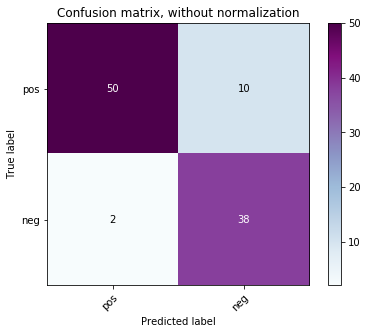

In [27]:
test_asian_iter = data.BucketIterator(test_asian_data, \
                                      batch_size=batch_size,
                                      sort_key = lambda x: len(x.text),
                                      sort_within_batch = True, 
                                      device=device, shuffle=True)

loss_asian, preds_asian, labels_asian = evaluate(model, test_asian_iter)

f1_asian = f1(preds_asian, labels_asian)
fpr_asian = fpr(preds_asian, labels_asian)
fnr_asian = fnr(preds_asian, labels_asian)
print(f'FPR: {fpr_asian:.5f} | FNR: {fnr_asian:.5f} | Train F1: {f1_asian:.5f}')

plot_confusion_matrix(labels_asian, preds_asian, classes = np.array(["pos", "neg"]), cmap = "BuPu")

FPR: 0.18644 | FNR: 0.07317 | Train F1: 0.84444
Confusion matrix, without normalization
[[48 11]
 [ 3 38]]


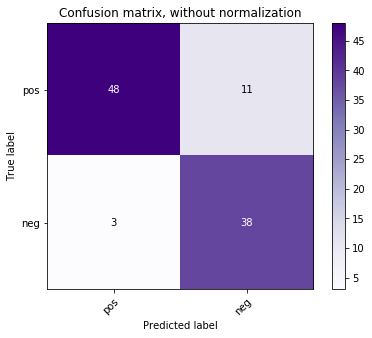

In [28]:
test_hispanic_iter = data.BucketIterator(test_hispanic_data, \
                                      batch_size=batch_size,
                                      sort_key = lambda x: len(x.text),
                                      sort_within_batch = True, 
                                      device=device, shuffle=True)

loss_hisp, preds_hisp, labels_hisp = evaluate(model, test_hispanic_iter)

f1_hisp = f1_score(preds_hisp, labels_hisp)
fpr_hisp = fpr(preds_hisp, labels_hisp)
fnr_hisp = fnr(preds_hisp, labels_hisp)
print(f'FPR: {fpr_hisp:.5f} | FNR: {fnr_hisp:.5f} | Train F1: {f1_hisp:.5f}')

plot_confusion_matrix(labels_hisp, preds_hisp, classes = np.array(["pos", "neg"]), cmap = "Purples")

(1.0, 1)    11487
(0.0, 0)    10364
(1.0, 0)     2136
(0.0, 1)     1013
dtype: int64


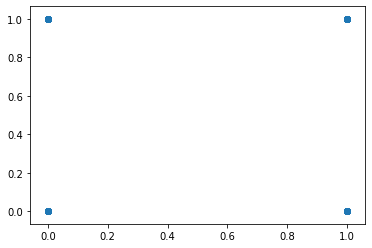

In [36]:
labels = []
for review in pooled_reviews:
    labels.append(review.label)

plt.scatter(preds_all, labels_all)
print(pd.Series(list(zip(preds_all, labels_all))).value_counts())

# To test the false positives, for each example let the response be -(1-y*)*log(1-p). This value should be close to zero if
# a true negative and high if the example was predicted as a false positive. Also consider -(1-y*)*(1-p).

# Model data as a binomial distribution Bin(n,p), where p is the probability that each example is a false positive. 
# Let X be the null distribution. 
# If each race has no bias, the expected number of false positive should follow E[X], where X ~ Bin(n,p). Take the actual
# false positive count for each race, and then compute the p-value for this distribution, being 1 - CDF_X_0(E[X_race])
# This is the right-tailed test.

# Choosing p for the null distribution is done as a prior. This can either be the FPR for the model's results on the entire
# dataset, or just for the pooled reviews. Note that this is the same as taking the MLE of the data.
# Preferredly choose p as the proportion of false positives of the pooled ethnic reviews. This guarantees 
# that the differences for each race is because of the complement of that race's reviews in the pool.

# We can also take as a null distribution one of the races as a baseline and compare each other race to that.

## Export model predictions (for t-test, ANOVA)

In [29]:
import pandas

data_all = {"preds": preds_all, "labels": labels_all}
df = pd.DataFrame(data=data_all, dtype=np.int64)
df.head()
df.to_csv("./data/all_measurements.csv", index = False)

preds = [preds_black, preds_white, preds_asian, preds_hisp]
labels = [labels_black, labels_white, labels_asian, labels_hisp]

names = ["black", "white", "asian", "hisp"]

dataframes = []

for i in range(0,4):
    d = {"preds": preds[i], "labels": labels[i]}
    df = pd.DataFrame(data=d, dtype=np.int64)
    dataframes.append(df)
    df.to_csv("./data/{}_measurements.csv".format(names[i]), index = False)

## Export contingency table (for Chi-squared test)

In [30]:
observations = []

for i in range(0,4):
    for pred in preds[i]:
        if pred == 0:
            observations.append([names[i], "neg"])
        else:
            observations.append([names[i], "pos"])


df = pd.DataFrame(np.array(random.sample(observations, len(observations))), columns = ["race", "sentiment"])

df.to_csv("./data/observations.csv", index = False)

pd.crosstab(df.race, df.sentiment)

sentiment,neg,pos
race,,
asian,52,48
black,47,53
hisp,51,49
white,59,41


## Captum Interpretation

In [31]:
model = torch.load('models/lstm.pt')
model.train()
model.to(device)

LSTMClassifier(
  (embedding): Embedding(10002, 100)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
  (act): Sigmoid()
)

In [112]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

PAD_IND = TEXT.vocab.stoi['pad']
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)

In [113]:
lig = LayerIntegratedGradients(model, model.embedding)


def forward_with_sigmoid(input):
    return torch.sigmoid(model(input))

# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len = 35, label = 0):
    text = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]
    
    length = [len(indexed)]
    
    print(length)

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(1).T
    
    
    # input_indices dim: [sequence_length]
    seq_length = min_len
    
    length_tensor = torch.LongTensor(length)

    # predict
    pred = model(input_indices, length_tensor).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=500, return_convergence_delta=True, \
                                           additional_forward_args = length_tensor)

    print('pred: ', LABEL.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            LABEL.vocab.itos[pred_ind],
                            LABEL.vocab.itos[label],
                            LABEL.vocab.itos[1],
                            attributions.sum(),       
                            text,
                            delta))

In [114]:
import spacy

nlp = spacy.load('en')

interpret_sentence(model, 'The US Department of Justice (DOJ) announced Friday that Keith Nelson, who was convicted in 2001 of the rape and murder of 10-year-old Pamela Butler, has been executed.', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

[35]
pred:  pos ( 0.94 ) , delta:  tensor([0.1340], device='cuda:0', dtype=torch.float64)
[35]
pred:  pos ( 0.99 ) , delta:  tensor([0.2999], device='cuda:0', dtype=torch.float64)
[35]
pred:  pos ( 1.00 ) , delta:  tensor([0.3326], device='cuda:0', dtype=torch.float64)
[35]
pred:  neg ( 0.00 ) , delta:  tensor([0.3762], device='cuda:0', dtype=torch.float64)
[35]
pred:  pos ( 0.70 ) , delta:  tensor([0.2550], device='cuda:0', dtype=torch.float64)
[35]
pred:  pos ( 0.95 ) , delta:  tensor([0.3005], device='cuda:0', dtype=torch.float64)


In [115]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients
